# DDPM Editing Experiment

This experiment aims at exploring the DDPM model's ability to edit images similar to the paper [SDEdit](https://github.com/ermongroup/SDEdit). 

There are two edit mode we are exploring in this notebook.
- **Global Editing**, where we edit the entire image.
- **Partial Editing**, where we edit a part of the image based on a mask. 

For both modes, we will test how the number of forward diffusion steps affects the quality (and diversity) of the generated image. 

For partial editing, we will additionally test the effect of the mask size on the quality (and diversity) of the generated image. 


In [1]:
import matplotlib.pyplot as plt
from models.viz_utils import save_sampling_video, visualize_elevation_map
from data_script.elevation_dataset import ElevationDataset
from models.ddpm_edit import Editor
import torch
from models.util import ScaleToRange, scale_to_range
import numpy as np
%load_ext autoreload
%autoreload 2

/home/sp/anaconda3/envs/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# original dataset, the output is scaled to [-1, 1]
dataset = ElevationDataset('/home/sp/Downloads/elevation')
# we use the same editor for both global and partial editing
editor = Editor("saved_models/model-182.pt")

torch.Size([1, 128, 128])


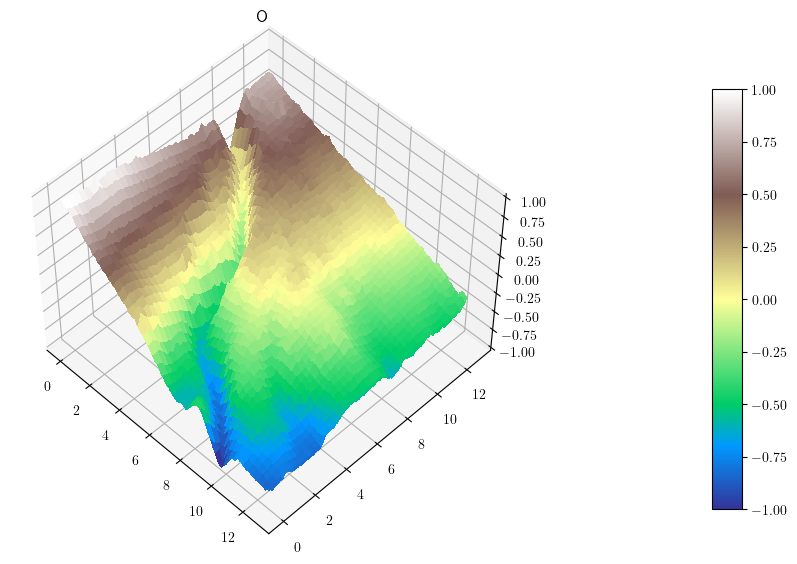

In [3]:
# randomly choose one terrain image to edit from the dataset
random_index = np.random.randint(0, len(dataset))
original_data_sample, _ = dataset[random_index]
original_data_sample = original_data_sample.to("cuda")
print(original_data_sample.shape)
visualize_elevation_map(original_data_sample, 1, 1, subtitles="Original", save_dir="./test_imgs/original.png")

In [12]:
import random
from PIL import Image, ImageDraw


def check_overlap(mask, shape_bbox):
    x1, y1, x2, y2 = shape_bbox
    subarea = mask.crop((x1, y1, x2, y2))
    return subarea.getbbox() is not None


def generate_mask(H, W, mask_area_ratio):
    mask = Image.new('1', (W, H), 0)
    draw = ImageDraw.Draw(mask)

    target_area = H * W * mask_area_ratio
    current_area = 0

    while True:
        shape = random.choice(['circle', 'rectangle', 'polygon'])
        new_area = 0
        bbox = ()

        if shape == 'circle':
            x1, y1 = random.randint(0, W), random.randint(0, H)
            r = random.randint(1, min(W, H) // 6)
            bbox = (x1 - r, y1 - r, x1 + r, y1 + r)
            new_area = round(3.14159 * r * r)

        elif shape == 'rectangle':
            x1, y1 = random.randint(0, W//2), random.randint(0, H//2)
            x2, y2 = random.randint(x1, W//2), random.randint(y1, H//2)
            bbox = (x1, y1, x2, y2)
            new_area = abs((x2 - x1) * (y2 - y1))

        elif shape == 'polygon':
            points_num = random.randint(3, 6)
            points = [(random.randint(0, W//2), random.randint(0, H//2)) for _ in range(points_num)]
            bbox = tuple(map(min, zip(*points))) + tuple(map(max, zip(*points)))

            # Calculate the area of the polygon using Shoelace formula
            x, y = zip(*points)
            new_area = int(0.5 * abs(sum(x[i - 1] * y[i] - x[i] * y[i - 1] for i in range(points_num))))
        if current_area + new_area <= target_area:
            if shape == 'circle':
                draw.ellipse(bbox, fill=1)
            elif shape == 'rectangle':
                draw.rectangle(bbox, fill=1)
            elif shape == 'polygon':
                draw.polygon(points, fill=1)
            current_area += new_area
        else:
            break

        if current_area >= target_area:
            break
    return mask


In [10]:
# preparations 
mask_area_ratio = [0.2, 0.4, 0.6, 1.0, 1.2, 1.6, 2.0]
num_samples = 20 
repeated_original_data_sample = original_data_sample.unsqueeze(dim=0).repeat(num_samples, 1, 1, 1)
# ts = torch.tensor([50, 100, 200, 400, 800, 1000], device=torch.device("cuda"))
ts = torch.tensor([1000], device=torch.device("cuda"))

<PIL.Image.Image image mode=1 size=128x128 at 0x7F887F4208E0>
<PIL.Image.Image image mode=1 size=128x128 at 0x7F887F420670>
<PIL.Image.Image image mode=1 size=128x128 at 0x7F887F4205B0>
<PIL.Image.Image image mode=1 size=128x128 at 0x7F887F4208E0>
<PIL.Image.Image image mode=1 size=128x128 at 0x7F887F420670>
<PIL.Image.Image image mode=1 size=128x128 at 0x7F887F4205B0>
<PIL.Image.Image image mode=1 size=128x128 at 0x7F887F4208E0>
Mask ratios 0.12646484375
Mask ratios 0.284423828125
Mask ratios 0.3109130859375
Mask ratios 0.3564453125
Mask ratios 0.5657958984375
Mask ratios 0.45733642578125
Mask ratios 0.64666748046875


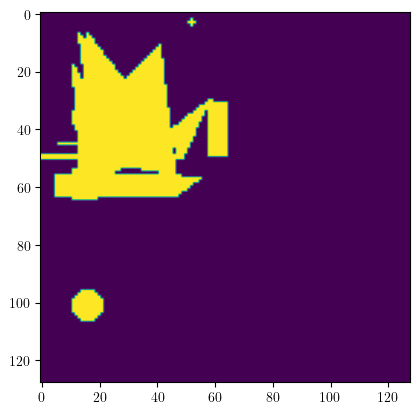

In [14]:
H, W = 128, 128
# the generated mask value is -1 and 0, where 0 means non-editable, and -1 means editable (masked out).
# since the mask ratio does not account for the overlapping area, it is possible that the actual mask ratio is smaller than the target ratio 
masks = [np.array(generate_mask(H, W, mask_area_ratio[i])) for i in range(len(mask_area_ratio))]
true_mask_ratio = []
for m in masks:
    print("Mask ratios", m.sum()/(H*W))
    true_mask_ratio.append(m.sum()/(H*W))
plt.imshow(masks[0])
plt.show()
masks = [-torch.from_numpy(mask).view(1, 1, 128, 128).
         repeat(num_samples, 1, 1, 1).
         to("cuda").float() 
         for mask in masks]

In [7]:
# final shape should be (# of masks, # steps, # samples, # diffusion_steps, C, H, W)
all_edited_samples = []
for mask in masks:
    edited_samples = []
    for i in range(ts.shape[0]):
        edited_x, all_edited_x = editor(repeated_original_data_sample, ts[i:i+1].item(), keep_intermediate=True, mask=mask)
        edited_samples.append(all_edited_x.cpu().detach().numpy())
        print("Shape", all_edited_x.shape)
    all_edited_samples.append(edited_samples)

sampling loop time step: 100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


Shape torch.Size([20, 1001, 1, 128, 128])


sampling loop time step: 100%|██████████| 1000/1000 [01:17<00:00, 12.88it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.22 GiB (GPU 0; 7.79 GiB total capacity; 4.91 GiB already allocated; 743.56 MiB free; 5.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def extract_final_sample(sample_seq):
    final_edited_samples = sample_seq[:, -1]
    if isinstance(sample_seq, torch.Tensor):
        # final_edited_samples = torch.stack(final_edited_samples, dim=0)
        final_edited_samples = final_edited_samples.view(-1, 128, 128)
    else:
        # final_edited_samples = np.stack(final_edited_samples, axis=0)
        final_edited_samples = final_edited_samples.reshape(-1, 128, 128)
    return final_edited_samples

In [ ]:
sample_1 = extract_final_sample(all_edited_samples[0][-1])
sample_2 = extract_final_sample(all_edited_samples[1][-1])
sample_3 = extract_final_sample(all_edited_samples[2][-1])
sample_4 = extract_final_sample(all_edited_samples[3][-1])
sample_5 = extract_final_sample(all_edited_samples[4][-1])

IndexError: list index out of range

In [ ]:
variances = np.array([
  np.var(sample_1, axis=0).sum()/masks[0][0].sum().item(),
  np.var(sample_2, axis=0).sum()/masks[1][0].sum().item(), 
  np.var(sample_3, axis=0).sum()/masks[2][0].sum().item(),
  np.var(sample_4, axis=0).sum()/masks[3][0].sum().item(),
  np.var(sample_5, axis=0).sum()/masks[4][0].sum().item(),
]) 
fig, axis = plt.subplots(1, 1, figsize=(8, 5))
axis.plot(true_mask_ratio, variances, marker='o')
print(true_mask_ratio[0], np.var(sample_1, axis=0).sum()/masks[0][0].sum())
print(true_mask_ratio[1], np.var(sample_2, axis=0).sum()/masks[1][0].sum())
print(true_mask_ratio[2], np.var(sample_3, axis=0).sum()/masks[2][0].sum())
print(true_mask_ratio[3], np.var(sample_4, axis=0).sum()/masks[3][0].sum())
print(true_mask_ratio[4], np.var(sample_5, axis=0).sum()/masks[4][0].sum())

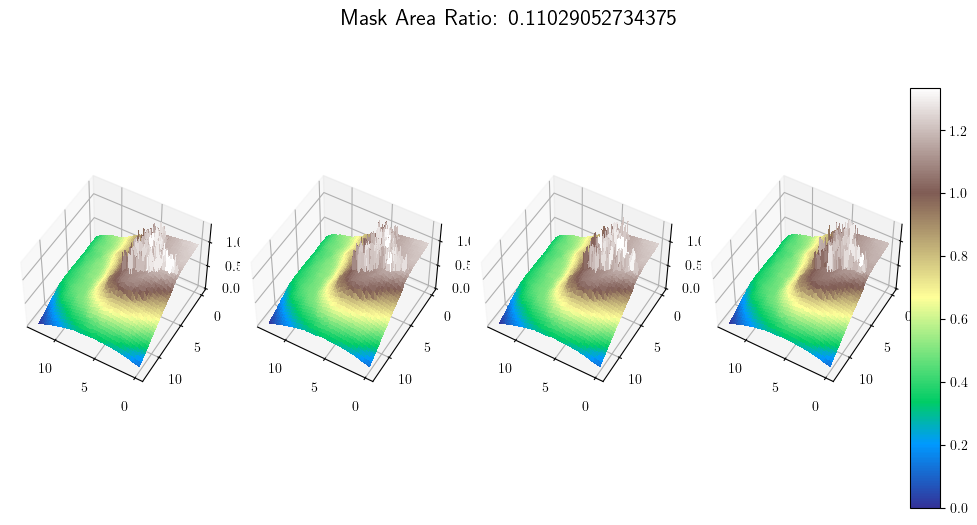

FileNotFoundError: [Errno 2] No such file or directory: 'media/partial_editing/mask_0.2.png'

In [ ]:
visualize_elevation_map(sample_1[:4], 1, 4, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[0]}", save_dir="media/partial_editing/mask_0.2.png")

In [ ]:
visualize_elevation_map(sample_2[:4], 1, 4, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[1]}", save_dir="media/partial_editing/mask_0.4.png")

In [ ]:
visualize_elevation_map(sample_3[:4], 1, 4, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[2]}", save_dir="media/partial_editing/mask_0.6.png")

In [ ]:
visualize_elevation_map(sample_4[:4], 1, 4, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[3]}", save_dir="media/partial_editing/mask_0.8.png")

In [ ]:
visualize_elevation_map(sample_5[:4], 1, 4, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[4]}", save_dir="media/partial_editing/mask_1.0.png")